In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. Data load

In [2]:
data_path = "./data/data.csv"
df = pd.read_csv(data_path)

X= df.iloc[:,2:-1]
y = df.iloc[:,1].replace({'B': '0', 'M': '1'}).astype("int")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# 2. Feature engineering

## 2.1 Shapiro wilk test(정규성 검정)
H0 : 데이터가 정규 분포를 따른다  
H1 : 데이터가 정규 분포를 따르지 않는다

In [3]:
nomality_list=[]
for column_name in X_train.columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    nomality_list.append(column_name)

print(nomality_list)

[]


모든 coloumn 에서 정규성을 확인하지 못했기때문에 비모수 검정인 Mann-Whitney U test 로 각 변수의 종속변수별 집단 분포가 서로 유의미한 차이를 가지는지 검정수행

## 2.2 Mann-Whitney U test
H0 : 두 집단의 분포가 동일하다  
H1 : 두 집단의 분포가 다르다  
우리는 각 변수에 대해 benign 집단과 malignant 집단의 분포가 유의미하게 다르길 원하기 때문에 Mann-Whitney U test 에서 가설이 기각된 column을 사용


In [4]:
# mannwhitneyu 검정
rejected_col_by_mannwhitneyu = []
accepted_by_mannwhitneyu = []
for column_name in X_train.columns:
  list_by_value = []
  for value in y.dropna().unique():
      df_tmp = df[y == value][column_name].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = mannwhitneyu(*list_by_value)
  if pvalue < 0.05:
    rejected_col_by_mannwhitneyu.append(column_name)
  else:
     accepted_by_mannwhitneyu.append(column_name)

print("rejected by mannwhitneyu : ", len(rejected_col_by_mannwhitneyu), rejected_col_by_mannwhitneyu)
print("acepted by mannwhitneyu : ", len(accepted_by_mannwhitneyu), accepted_by_mannwhitneyu)

rejected by mannwhitneyu :  27 ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
acepted by mannwhitneyu :  3 ['fractal_dimension_mean', 'texture_se', 'smoothness_se']


실제로 Mann-Whitney U test에서 채택된 coloumn의 두 집단 분포가 서로 비슷한지 시각화로 확인

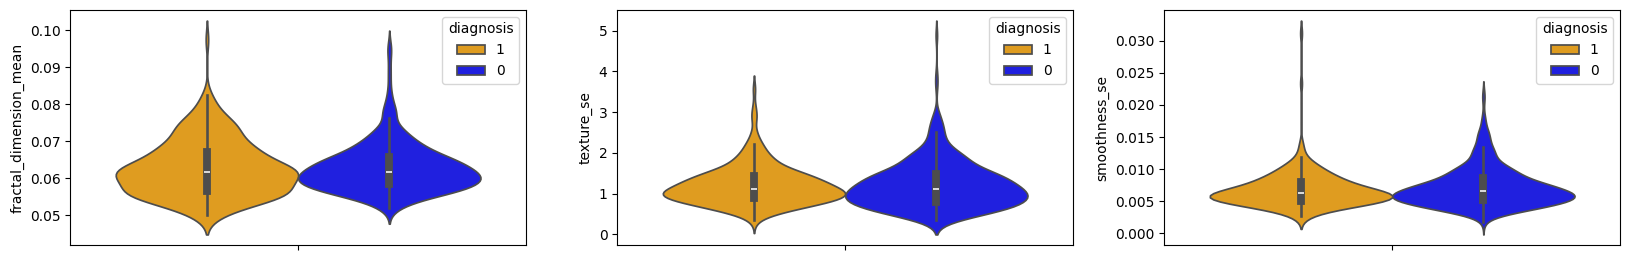

In [5]:
plt.figure(figsize=(20, ((len(X[accepted_by_mannwhitneyu].columns) // 3) + 1) * 3))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.2)

for column_name in X[accepted_by_mannwhitneyu].columns:
    plt.subplot((len(X[accepted_by_mannwhitneyu].columns) // 3) + 1, 3, x)
    x += 1
    sns.violinplot(data=df, x=None, y=column_name, hue=y.astype(str), 
                   palette={"0": "blue", "1": "orange"})  # hue로 y 전달, legend 비활성화
plt.show()


In [6]:
X_train=X_train[rejected_col_by_mannwhitneyu]
X_test=X_test[rejected_col_by_mannwhitneyu]

# Correlation matrix로 상관성이 높은 변수 제거

In [7]:
# 상관계수 계산
correlation_matrix = X_train.corr()

# 상관계수 0.95 이상인 변수 쌍 찾기
high_corr = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
             if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.95]

# 결과 출력
print("상관계수 0.95 이상인 변수 쌍:")
for high_corr_set in high_corr:
    print(high_corr_set)

상관계수 0.95 이상인 변수 쌍:
('radius_mean', 'perimeter_mean')
('radius_mean', 'area_mean')
('radius_mean', 'radius_worst')
('radius_mean', 'perimeter_worst')
('perimeter_mean', 'radius_mean')
('perimeter_mean', 'area_mean')
('perimeter_mean', 'radius_worst')
('perimeter_mean', 'perimeter_worst')
('area_mean', 'radius_mean')
('area_mean', 'perimeter_mean')
('area_mean', 'radius_worst')
('area_mean', 'perimeter_worst')
('area_mean', 'area_worst')
('radius_se', 'perimeter_se')
('perimeter_se', 'radius_se')
('radius_worst', 'radius_mean')
('radius_worst', 'perimeter_mean')
('radius_worst', 'area_mean')
('radius_worst', 'perimeter_worst')
('radius_worst', 'area_worst')
('perimeter_worst', 'radius_mean')
('perimeter_worst', 'perimeter_mean')
('perimeter_worst', 'area_mean')
('perimeter_worst', 'radius_worst')
('perimeter_worst', 'area_worst')
('area_worst', 'area_mean')
('area_worst', 'radius_worst')
('area_worst', 'perimeter_worst')


### 제거 후보 목록

1. **`perimeter_mean`, `perimeter_worst` 제거**
   - `perimeter`는 `radius` 및 `area`와 중복적인 정보를 제공하므로 제거 가능합니다.

2. **`radius_mean` 또는 `radius_worst` 중 하나 제거**
   - 둘 다 세포 크기를 설명하는 변수이므로 하나만 유지해도 충분합니다.
   - `radius_mean`은 평균값으로 안정적인 지표를 제공하므로, `radius_worst` 제거를 추천합니다.

3. **`area_mean` 또는 `area_worst` 중 하나 제거**
   - `area_worst`는 극단값으로 데이터 변동성을 더 많이 포함할 수 있습니다. 따라서 `area_mean` 제거를 고려합니다.

4. **`radius_se`, `perimeter_se` 제거**
   - `SE`(표준 오차)는 주요 특성의 변동성을 나타내는 보조적 지표입니다.
   - `radius_se`와 `perimeter_se`가 상관관계가 높으므로, 둘 중 하나만 유지합니다. 일반적으로 `radius_se`가 임상적으로 더 해석이 용이합니다.


In [8]:
columns_to_drop = ['perimeter_mean', 'perimeter_worst', 'radius_worst', 'area_mean', 'perimeter_se']

# 변수 제거
X_train=X_train.drop(columns=columns_to_drop)
X_test=X_test.drop(columns=columns_to_drop)

# 3. Model training

## 3.1 Make final X , split data, and standardization

In [9]:
scaler =  StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

# Logistic Regression

lgleg f1_score :  0.9925925925925926


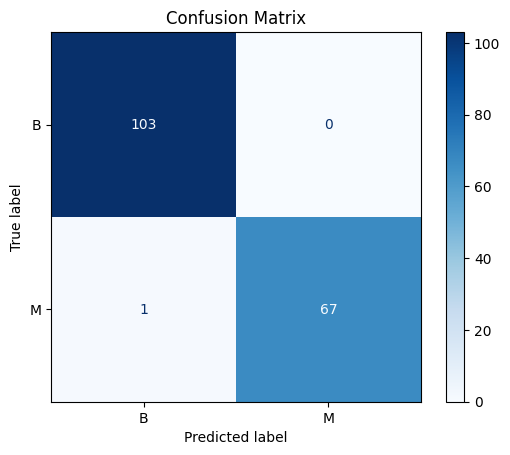

In [10]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logleg = logreg.predict(X_test_scaled)  ##

logreg_f1 = f1_score(y_test, y_pred_logleg)

print("lgleg f1_score : ", logreg_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_logleg), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Support vector machine

svc f1_score :  0.9925925925925926


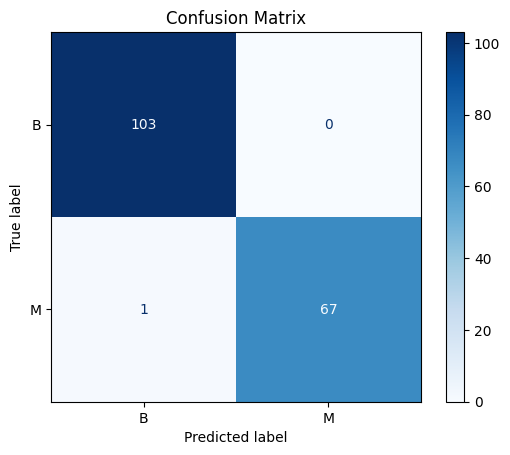

In [11]:
svc = SVC(kernel="linear")
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)  ##

svc_f1 = f1_score(y_test, y_pred_svc)

print("svc f1_score : ", svc_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svc), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Random Forest

f1_score :  0.9852941176470589


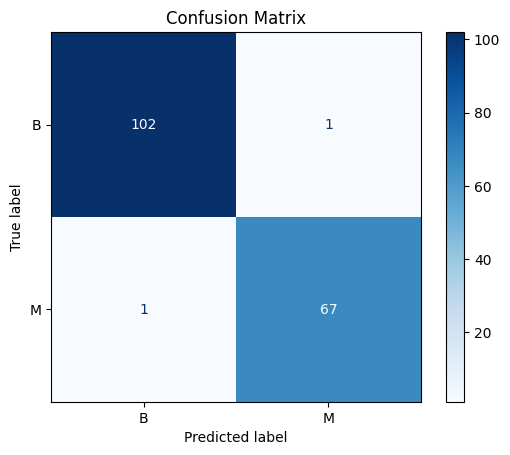

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

rf_f1 = f1_score(y_test, y_pred_rf)

print("f1_score : ", rf_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Xgboost

f1_score :  0.9705882352941176


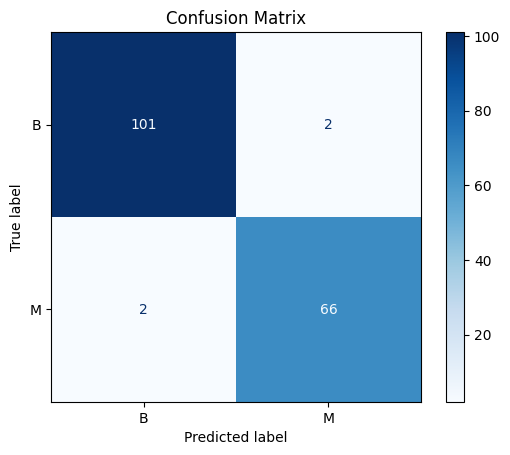

In [13]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)  ##

xgb_f1 = f1_score(y_test, y_pred_xgb)

print("f1_score : ", xgb_f1)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb), display_labels=["B", "M"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [14]:
print ('F1_score Comparisons for Binary Models\n')
print ('logreg_score:', '{0:0.5f}'.format(logreg_f1))
print ('svc_score   :', '{0:0.5f}'.format(svc_f1))
print ('rfc_score   :', '{0:0.5f}'.format(rf_f1))
print ('xgb_score   :', '{0:0.5f}'.format(xgb_f1))


F1_score Comparisons for Binary Models

logreg_score: 0.99259
svc_score   : 0.99259
rfc_score   : 0.98529
xgb_score   : 0.97059


# 4 Model analysis

loglag coefficient :  ['area_worst', 'radius_mean', 'area_se', 'radius_se', 'concave points_worst', 'texture_worst', 'symmetry_worst', 'concave points_mean', 'concavity_mean', 'smoothness_worst', 'concavity_worst', 'texture_mean', 'concave points_se', 'symmetry_mean', 'compactness_worst', 'concavity_se', 'fractal_dimension_worst', 'smoothness_mean', 'compactness_mean', 'compactness_se', 'fractal_dimension_se', 'symmetry_se']


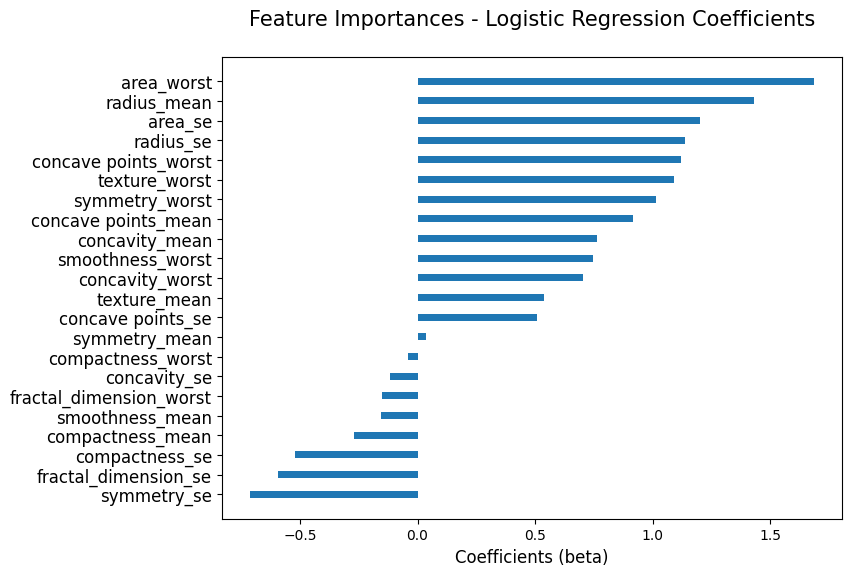

In [15]:
indices =  np.argsort(sum(logreg.coef_))
print("loglag coefficient : ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(8, 6))
plt.barh(X_test.columns, sum(logreg.coef_)[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients (beta)', fontsize=12)
plt.title('Feature Importances - Logistic Regression Coefficients\n', fontsize=15)
plt.show()

svc coefficient :  ['area_worst', 'area_se', 'symmetry_worst', 'concavity_mean', 'texture_worst', 'concave points_mean', 'concave points_se', 'concavity_worst', 'radius_mean', 'smoothness_worst', 'radius_se', 'concave points_worst', 'texture_mean', 'fractal_dimension_worst', 'compactness_mean', 'symmetry_mean', 'compactness_worst', 'compactness_se', 'smoothness_mean', 'fractal_dimension_se', 'concavity_se', 'symmetry_se']


<Figure size 800x600 with 0 Axes>

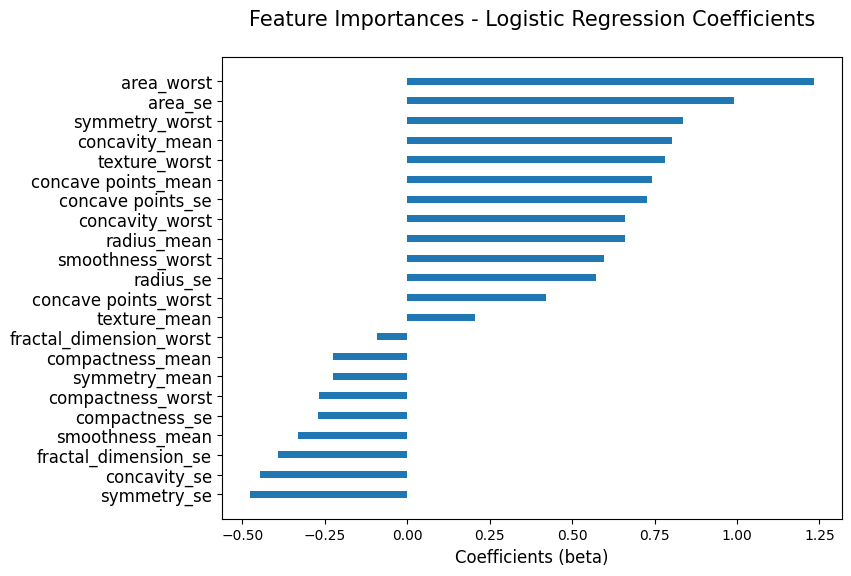

In [16]:
indices =  np.argsort(sum(svc.coef_))
print("svc coefficient : ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
plt.barh(X_test.columns, sum(svc.coef_)[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)
plt.xlabel('Coefficients (beta)', fontsize=12)
plt.title('Feature Importances - Logistic Regression Coefficients\n', fontsize=15)
plt.show()

rf important col:  ['area_worst', 'concave points_worst', 'concave points_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'texture_worst', 'compactness_mean', 'radius_se', 'texture_mean', 'compactness_worst', 'fractal_dimension_se', 'smoothness_worst', 'smoothness_mean', 'fractal_dimension_worst', 'symmetry_worst', 'concave points_se', 'symmetry_se', 'concavity_se', 'compactness_se', 'symmetry_mean']


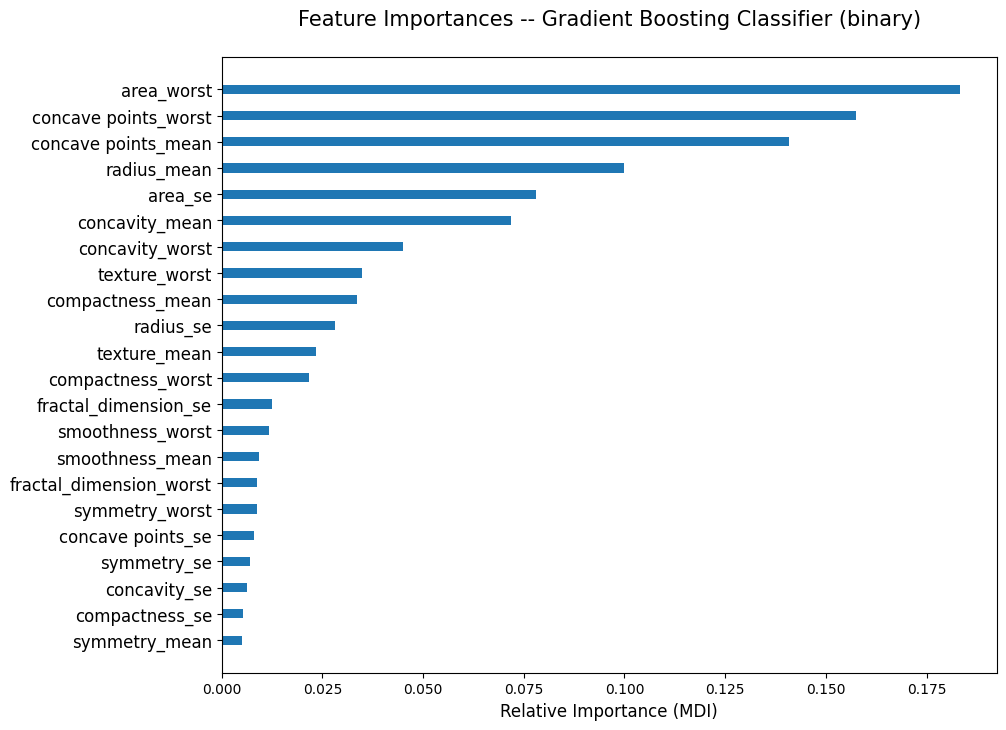

In [17]:
indices = np.argsort(rf.feature_importances_)  # 중요도 크기 순으로 정렬
print("rf important col: ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, rf.feature_importances_[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- Gradient Boosting Classifier (binary)\n', fontsize=15)
plt.show()

xgb important col:  ['concave points_mean', 'area_worst', 'concave points_worst', 'texture_worst', 'radius_mean', 'concavity_worst', 'texture_mean', 'compactness_se', 'area_se', 'fractal_dimension_se', 'symmetry_se', 'concavity_mean', 'smoothness_worst', 'symmetry_mean', 'radius_se', 'smoothness_mean', 'compactness_mean', 'symmetry_worst', 'concave points_se', 'concavity_se', 'fractal_dimension_worst', 'compactness_worst']


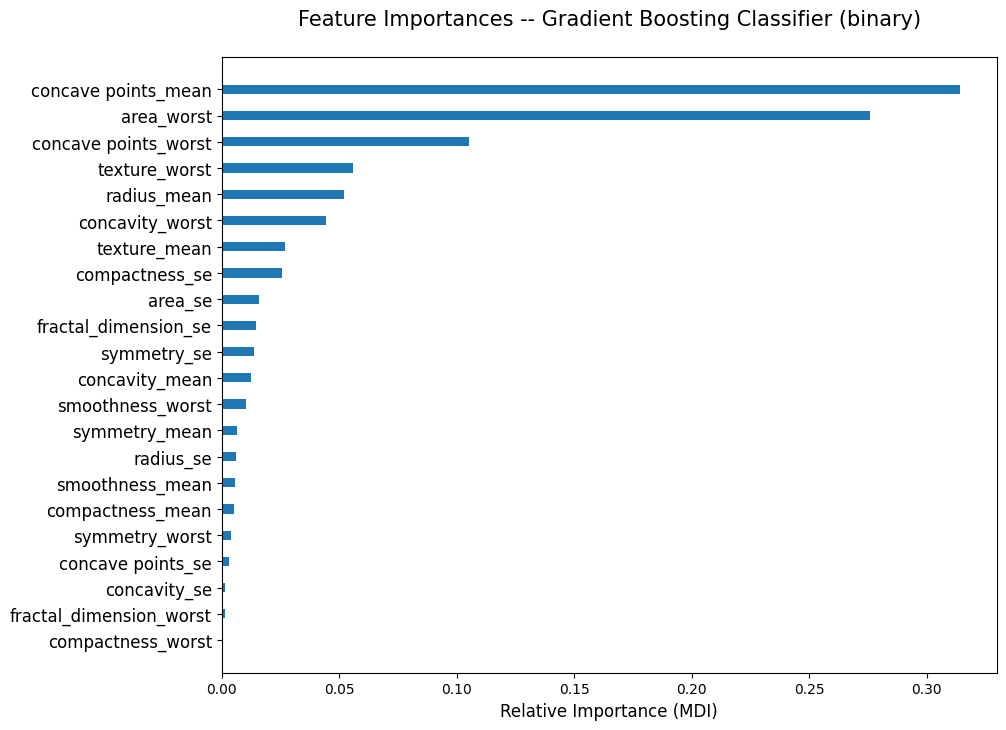

In [18]:
indices = np.argsort(xgb.feature_importances_)  # 중요도 크기 순으로 정렬
print("xgb important col: ", X_test.columns[np.flip(indices)].to_list())
plt.figure(figsize=(10, 8))

plt.barh(X_test.columns, xgb.feature_importances_[indices], .35, align='center')
plt.yticks(X_test.columns, X_test.columns[indices], fontsize=12)

plt.xlabel('Relative Importance (MDI)', fontsize=12)
plt.title('Feature Importances -- Gradient Boosting Classifier (binary)\n', fontsize=15)
plt.show()